In [689]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

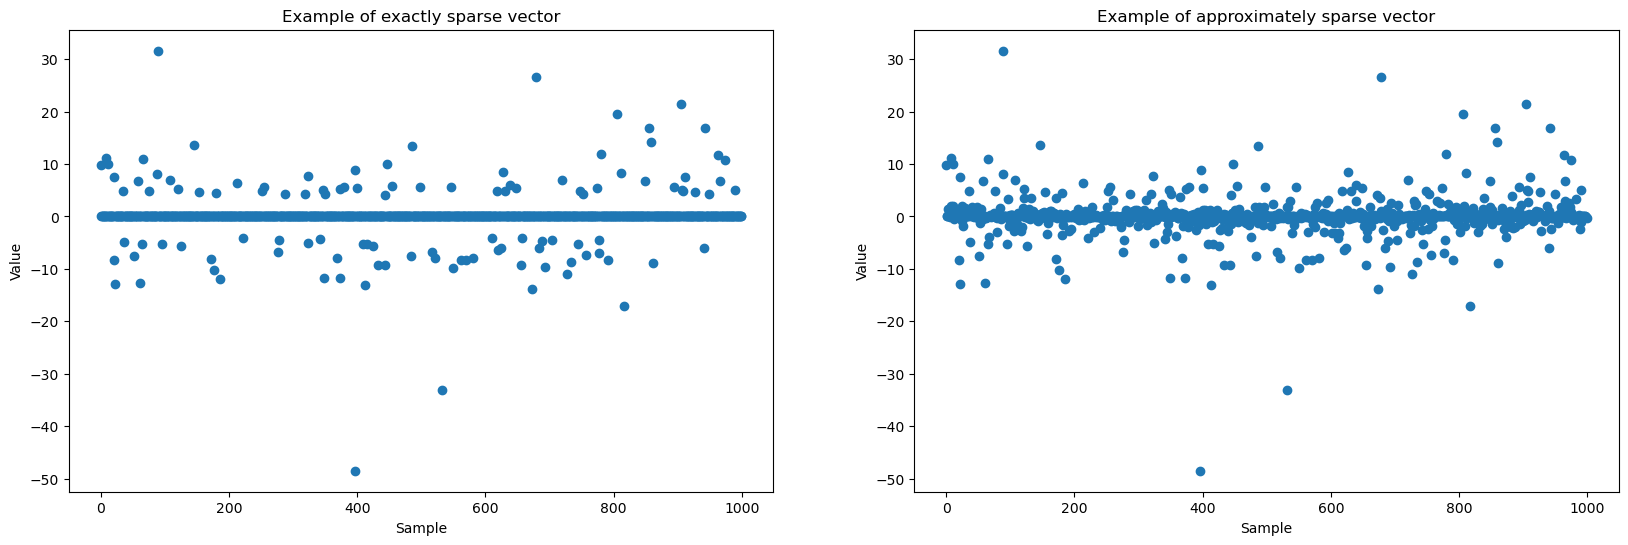

In [690]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

**Answer:** An exactly sparse signal is a signal that can be represented using only a small number of non-zero coefficients in a particular basis or representation system. A signal $s \in R ^ {n}$ is said to be k-sparse if only $k << t$ of its elements are non-zeros.

$ ||s||_0 = k << t $

An approximately sparse signal is a signal that can be represented using a relatively small number of non-zero coefficients in a particular basis or representation system, **but with some small residual error**. 

$ ||s||_0 = k \approx t $

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

**Answer:** The scatter plot of the sources has a star shape due to sparsity generated by the power-law distribution of the sources. The power-law distribution implies that only a small number of data points have significant values, while the majority of data points have lower values. 

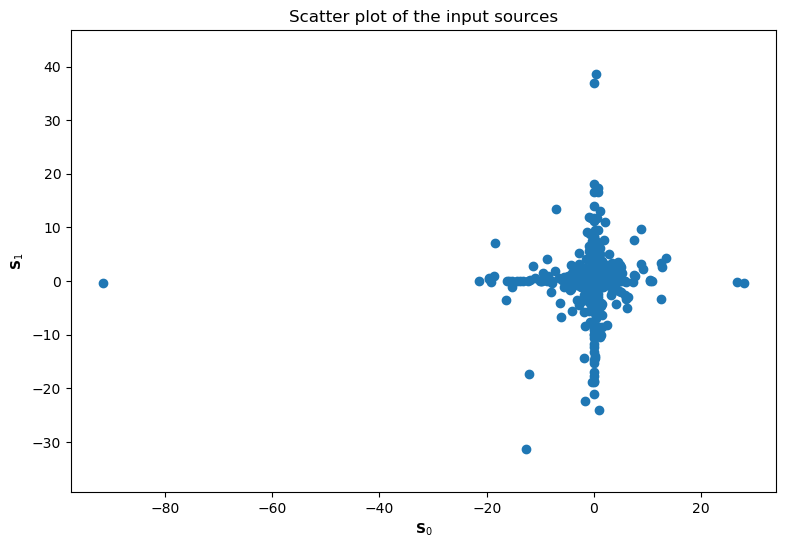

In [691]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 3 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
# S = np.zeros(n,t) # TO CHANGE
S = np.random.randn(n,t)**power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [692]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ? 

**Answer:** It is possible to observe that the data points are now distributed along different directions. 

What do the directions of the lines you observe correspond ?

**Answer:** In the context of Hyperspectral Imaging and Blind Source Separation, the directions of the lines correspond to the signatures of the different endmembers present in the scene. Each endmember contributes to the final observed data in a certain proportion defined by the mixing matrix A. In a noiseless situation, it is expected the data points being aligned along straight lines or curves, each representing an endmember.

Try several A matrices, noise_values and powers. Any comment?

**Answer:** 

Changing the A matrix is equivalent to changing the mixing proportions of the different endmembers in the scene. Different A matrices result in different distributions of points in the scatter plot, reflecting different mixing scenarios.

Altering the noise level affects the quality of the observations. Higher noise levels make the source separation task more difficult because the true signal is more obscured. In the scatter plot, when increasing the noise level, it is possible to observe an increased scattering of points away from the ideal lines or curves representing the endmembers.

Changing the power affects the distribution of the original sources. A higher power makes the source signals more heavy-tailed. This might be relevant depending on the specific distributions of the endmember spectra in the hyperspectral image.





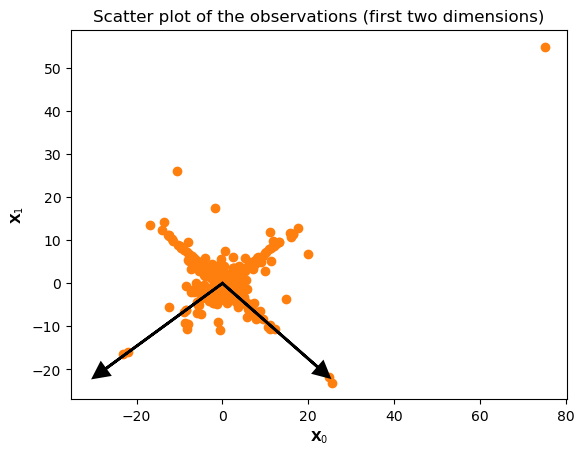

In [693]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

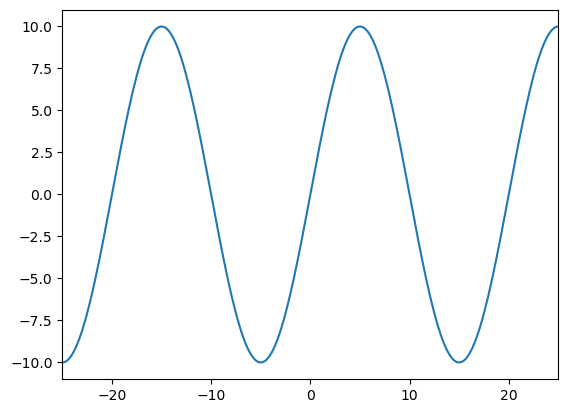

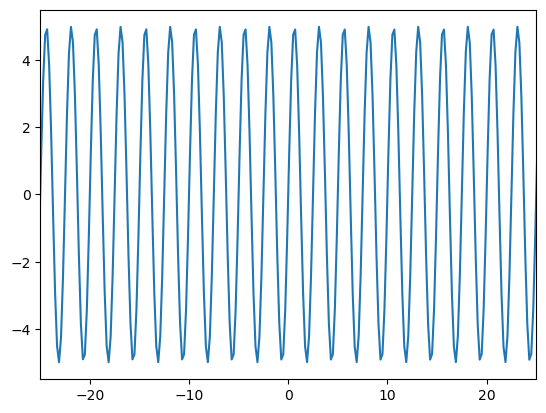

In [694]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

- What is the objective of using the DCT?

**Answer:** The objective of using the Discrete Cosine Transform (DCT) is to represent a signal or data in a more compact and energy-concentrated form. The DCT is a widely used transform technique in signal processing and data compression applications.

- Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

**Answer:** The absolute value of the DCT of the two sines shows two peaks at the frequencies of the sinusoids in the original signals. Specifically, for S[0, :] it is possible to observe a peak at 0.05 and for S[1, :] a peak at 0.4. 

When applying DCT, the signals are decomposed into their constituent frequencies. Since the original signal are pure sinusoids, they contain only a single frequency each. Therefore, when plotting the absolute values of the DCT of the signals, it is possible to observe peaks at these frequencies.


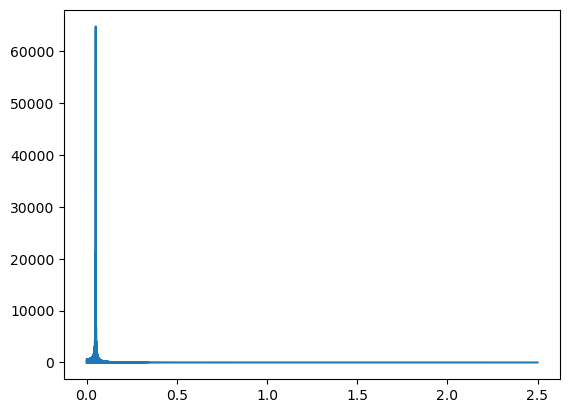

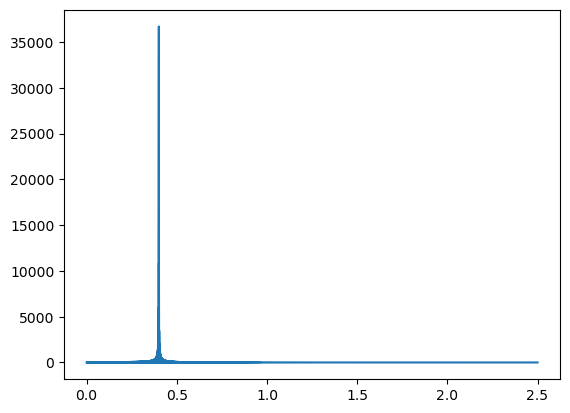

In [695]:
# Transformation into the DCT domain
Sf = sff.dct(S)

plt.figure()
plt.plot(np.linspace(0,2.5,t), np.abs(Sf[0,:]))
plt.figure()
plt.plot(np.linspace(0,2.5,t), np.abs(Sf[1,:]))

# limit the plots to the frequency with the highest energy
# plt.figure()
# plt.plot(np.abs(Sf[0,:]))
# plt.xlim([np.argmax(np.abs(Sf[0,:]))-10,np.argmax(np.abs(Sf[0,:]))+10])
# plt.figure()
# plt.plot(np.abs(Sf[1,:]))
# plt.xlim([np.argmax(np.abs(Sf[1,:]))-10,np.argmax(np.abs(Sf[1,:]))+10])


Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

**Answer:** The mixture X is a combination of the two sinusoids in S, but obscured due to the mixing and the added noise. 

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

**Answer:** The DCT of X shows peaks at the same frequencies as in the originals signals (0.05 and 0.4), as these are the frequencies that were present in the original sources S. However, because of the mixing and the added noise, these peaks are less pronounced compared to the DCT of the original signals. In addition, it is possible to see some small additional peaks at other frequencies, due to the noise. 

To recover the sources we can benefit from the fact that the DCT of the mixtures retains peaks at the frequencies of the original sources. Since the **DCT is able to separate signals based on their frequency content**, it is possible to recover the sources by indentifying the frequencis with significant contributions and using this information to aid in the source separation process. 

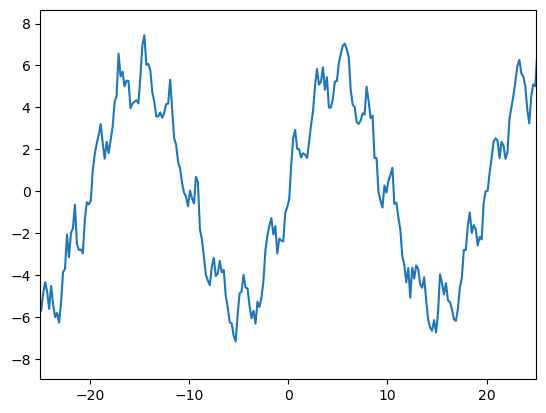

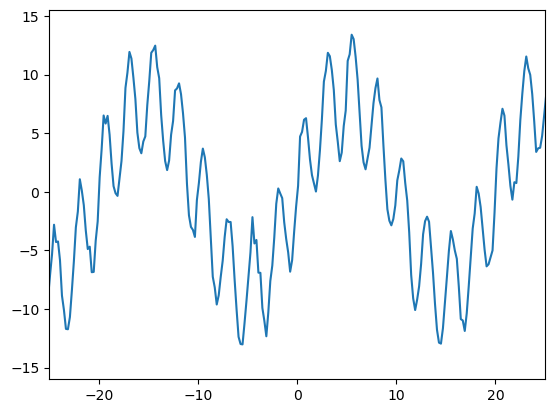

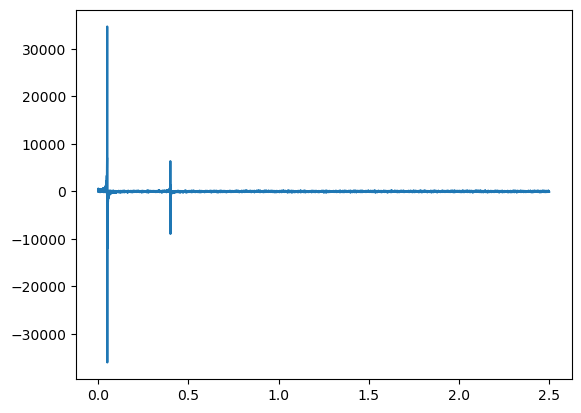

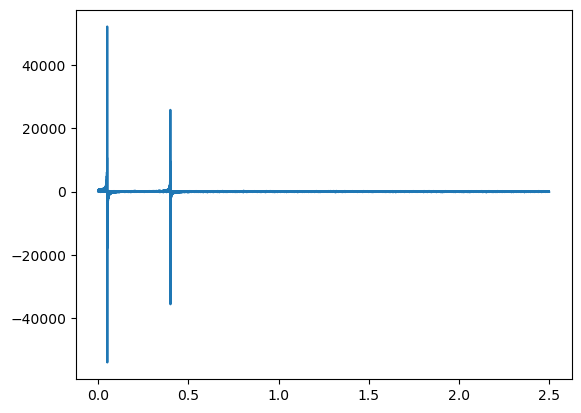

In [696]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

Xf = sff.dct(X)

plt.figure()
plt.plot(x_abs, X[0,:])
plt.xlim([-25,25])
plt.figure()
plt.plot(x_abs, X[1,:])
plt.xlim([-25,25])

plt.figure()
plt.plot(np.linspace(0, 2.5, t), Xf[0,:])
plt.figure()
plt.plot(np.linspace(0, 2.5, t), Xf[1,:])



**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

**Answer:** The cost function is given by the following expression: 

$ \argmin_{A \in R^{m \times n}, S \in R^{m \times n}} \frac{1}{2} ||X - AS||_F^2 + \lambda ||S||_1 $


- Data Fidelity Term: $ \frac{1}{2} ||X - AS||_F^2 $ : This term measures the discrepancy between the observed data X and the estimated data AS (where A is the known mixing matrix and S is the source matrix to be estimated). The goal is to find an S such that AS is as close as possible to X. This term is smooth and convex, as it's a squared L2 norm, which is differentiable with a unique minimum.

- Sparsity Term: $ \lambda ||S||_1 $ : his term encourages the solution to be sparse. It's the L1 norm of S (the sum of the absolute values of the elements of S), weighted by a regularization parameter $\lambda$. The L1 norm promotes sparsity by effectively "penalizing" solutions with many non-zero elements. This term is non-smooth due to the absolute value operation, but it's convex.

Compute the gradient along the S variable of the data-fidelity term.

**Answer:** The gradient of the data-fidelity term is given by the following expression:

$ \nabla_S \frac{1}{2} ||X - AS||_2^F = -A^T(X - AS) $

Recall what the proximal operator of the l1-norm is.

**Answer:** The proximal operator of the l1-norm is given by the following expression:

$ prox_{\lambda ||.||_1}(S) = sign(S) \odot max(|S| - \lambda, 0) $

Or equivalently:

$ prox_{\lambda ||.||_1}(v)_{i} = S_{\lambda}(v) = $
$ \begin{cases} 
      v_i - \lambda & v_i > \lambda \\
      0 & |v_i| \leq \lambda \\
      v_i + \lambda & v_i < -\lambda
      \end{cases}
$




In [697]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
    # To complete

    # soft thresholding operator
    S_est = np.sign(S_est) * np.maximum(np.abs(S_est) - thrd, 0)
   
    return S_est



Explain the main idea of the ISTA algorithm. Then, implement it.

**Answer:** The Iterative Shrinkage-Thresholding Algorithm (ISTA) is a method designed to solve optimization problems that involve a convex, differentiable function plus a non-smooth, convex penalty term. 

The main idea of the Iterative Shrinkage-Thresholding Algorithm (ISTA) is to iteratively estimate the sparse representation of a signal by applying a series of thresholding and shrinkage operations. ISTA is commonly used for solving sparse signal recovery problems, such as compressed sensing or sparse regression.


In [698]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):

    k = 0 # iteration counter
    S_est = np.zeros((n,np.shape(X)[1])) # initialization of the source estimate
    S_est_old = S_est # initialization of the source estimate at the previous iteration
    
    L = np.linalg.norm(A.T@A,2) # Lipschitz constant of the gradient of the cost function
    gamma = 0.9/L # step size
    
    thrd = lamb # threshold value for the proximal operator
    
    # TO DO: implement the ISTA algorithm
    while k < nbIt:
        # To complete
        S_est = prox_l1(S_est_old - gamma*A.T@(A@S_est_old - X), thrd)
        k = k + 1
        S_est_old = S_est 
    
    return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

**Answer:** The minimum value we should not go below is 0. If $\lambda \leq 0$ it would effectively reverse the role of the L1 regularization term in the cost function, encouraging a denser solution. 

If $\lambda$ is too large, the algorithm will strongly prioritize sparsity, potentially at the expense of data fidelity. This can lead to underfitting, where the algorithm fails to capture the underlying signal in the data. In the extreme case where $\lambda$ is very large, the solution is likely to be overly sparse (potentially all zeros), and may not fit the data well.



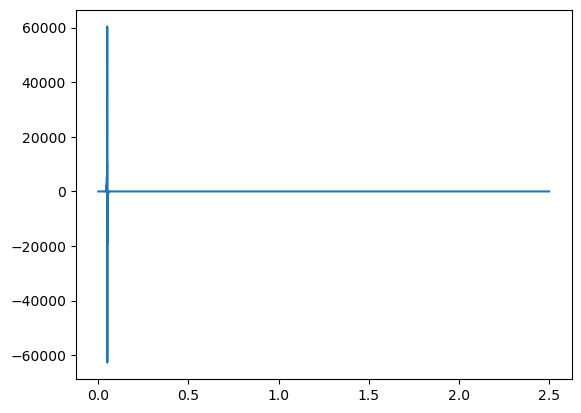

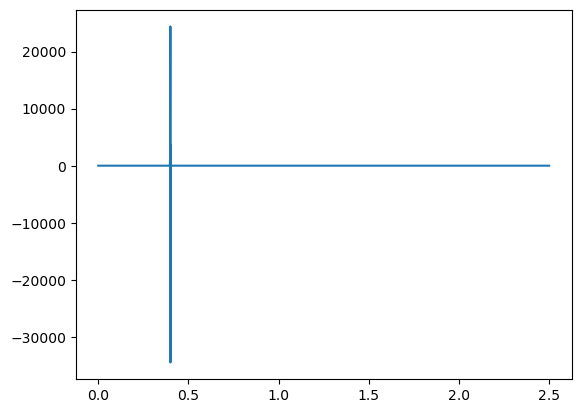

In [699]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)

# try various lamb values and look at the results 

# lbd = [0.00000000001,1,10,100,1000,1000000000000000]

# for lamb in lbd:
#     S_estf = ISTA(Xf,A = A,n=2,lamb=lamb,nbIt = 1000)
#     plt.figure()
#     plt.plot(S_estf[0,:])
#     plt.figure()
#     plt.plot(S_estf[1,:])

S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)
plt.figure()
plt.plot(np.linspace(0, 2.5, t), S_estf[0,:])
plt.figure()
plt.plot(np.linspace(0, 2.5, t), S_estf[1,:])


Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

**Answer:** Plotting the estimated sources in the DCT domain and looking to the amplitude values near the peaks, it is possible to observe that the sources are approximately sparse. Most of the energy of the signal is concentrated in some coefficients (corresponding to the same frequencies of the sinusoids) in the transform domain, while the rest of the coefficients are close to zero. 

(-25.0, 25.0)

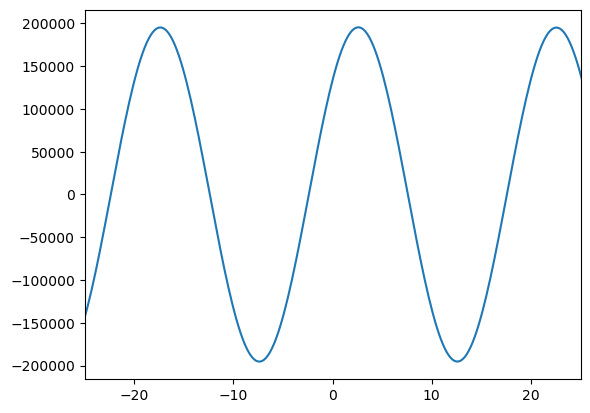

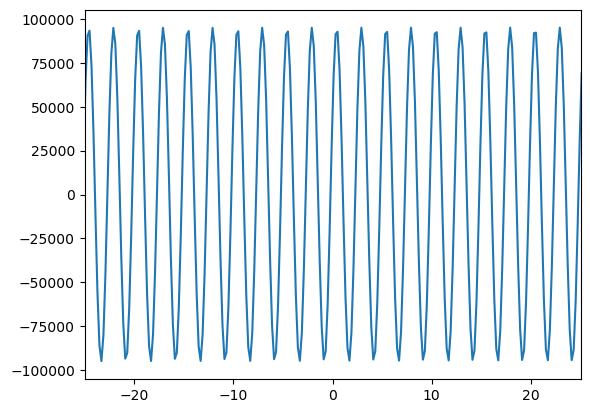

In [700]:
Sf = sff.dct(S_estf)

plt.figure()
plt.plot(x_abs, Sf[0,:])
plt.xlim([-25,25])
plt.figure()
plt.plot(x_abs, Sf[1,:])
plt.xlim([-25,25])


Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

**Answer:** It is possible to observe that the estimatedd source resemble the original sources in terms of general shape and structure (sinusoidal). However, there is a phase shift between the original and estimated sources. 

Since we are dealing with mixed signals derived from two different original sources, the algorithm is not capable to perfectly reconstruct the original signals. One commom discrepancy is a phase shift. 

This happens because the algorithm is trying to "unmix" the signals without any knowledge of the original alignment (or phase) of the sources. It is generally only able to recover the sources up to certain indeterminacies, which often includes phase shifts or permutations of the sources.

On the other hand, a phase  shift doesn't necessarily mean the source separation was unsuccessful. The important feature is that the overall shape (or pattern) of the source signal is preserved. For instance, in this case, since we know that the original sources are two periodic signals with known frequency, it is possible to use this information to estimate and correct the phase shift. 



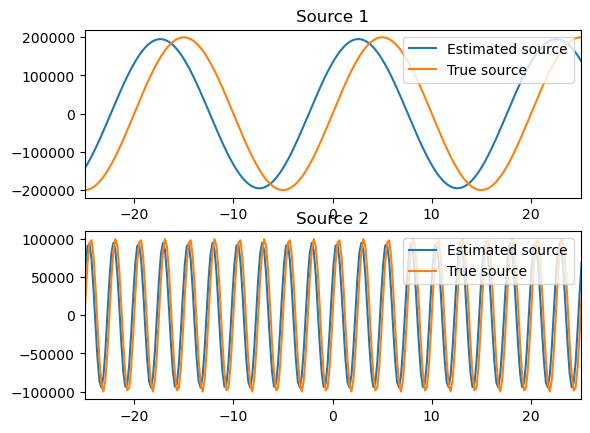

In [701]:
## improvement of the plots with subplots and titles and legends
plt.figure()
plt.subplot(2,1,1)
plt.plot(x_abs, Sf[0])
plt.plot(x_abs, S[0]*20000)
plt.xlim([-25,25])
plt.title('Source 1')
plt.legend(['Estimated source','True source'], loc='upper right')

plt.subplot(2,1,2)
plt.plot(x_abs, Sf[1])
plt.plot(x_abs, S[1]*20000)
plt.xlim([-25,25])
plt.title('Source 2')
plt.legend(['Estimated source','True source'], loc='upper right')

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?

**Answer:**

The cost function is given by the following expression:

$ \argmin_{A \in R^{m \times n}, S \in R^{m \times n}} \frac{1}{2} ||X - AS||_F^2 + \lambda ||S||_1 + \iota_{ {i \in [1,n]; ||a_{i,j}||l_{2}^2 \leq 1 }}(A) $

- Data Fidelity Term: $ \frac{1}{2} ||X - AS||_F^2 $ : This is the data fidelity term. It measures the discrepancy between the observed mixed signals X and the signals AS generated by the current estimates of A and S. The goal is to minimize this discrepancy. This term is smooth and convex because it is a quadratic function of A and S.

- Sparsity Term: $ \lambda ||S||_1 $ : his is the regularization term. It imposes a penalty based on some measure of the sparsity of S.

- Oblique constraint $\iota_{ {i \in [1,n]; ||a_{i,j}||l_{2}^2 \leq 1 }}(A) $ : his constraint forces the columns of the mixing matrix A to have a unit norm, which means that each column vector has a length or magnitude of 1. This constraint is used to deal with the inherent scale ambiguity in blind source separation problems. Without any constraints, the problem would have an infinite number of solutions because any scaling of the sources can be counterbalanced by an inverse scaling of the mixing matrix. By forcing the columns of A to have a unit norm, this scale ambiguity is removed, which makes the problem better-posed and easier to solve. This is a non convex constraint.




Recall what the gradient of the data fidelity term over A is.

**Answer:** The gradient of the data-fidelity term over A is given by the following expression:

$ \nabla_A \frac{1}{2} ||X - AS||_F^2 = -S^T(X - AS) $

Compte the proximal operator of the oblique constraint. Implement it.

In [702]:
def prox_oblique(A):
   # TO DO   

   for j in range(A.shape[1]):
      A[:,j] = A[:,j]/max(1, np.linalg.norm(A[:,j]))
       
   return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [703]:
def PALM(X,n=2,lamb=0,nbIt = 100):
   
   # TO DO
   S_est = np.zeros((n,X.shape[1])) # initialization of the source estimate
   A_est = np.eye(X.shape[0],n) # initialization of the mixing matrix estimate
   
   k = 0 # iteration counter
   
   thrd = lamb # threshold value for the proximal operator
   
   while k < nbIt:
      L_S = np.linalg.norm(S_est@S_est.T) # Lipschitz constant of the gradient of the cost function
      L_A = np.linalg.norm(A_est.T@A_est) # Lipschitz constant of the gradient of the cost function
      gamma_A = 0.9/(L_S + 1e-17) # step size
      gamma_S = 0.9/(L_A + 1e-17) # step size
      S_est = prox_l1(S_est + gamma_S*A_est.T@(X - A_est@S_est), thrd)
      A_est = prox_oblique(A_est + gamma_A*(X - A_est@S_est)@ S_est.T)
      k+=1 
   
   return A_est,S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

**Answer:** As it is possible to observe, making a visually inspection of the true and estimated sources, the separation quality is very good. The estimated sources closely resemble the original ones. There is not any significant scale factor, phase shift or permutation. A small phase shift is noticeable, however it is smaller than the one observed in the non-blind source separation case.

In addition, the true and estimated A matrices are very similar, indicating that the PALM algorithm has been successful at "unmixing" the sources from the observed data.

(-25.0, 25.0)

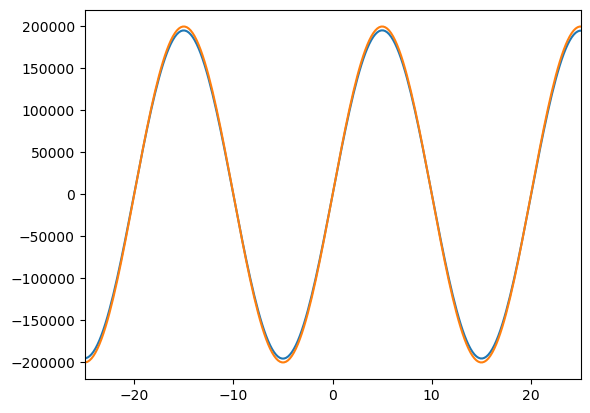

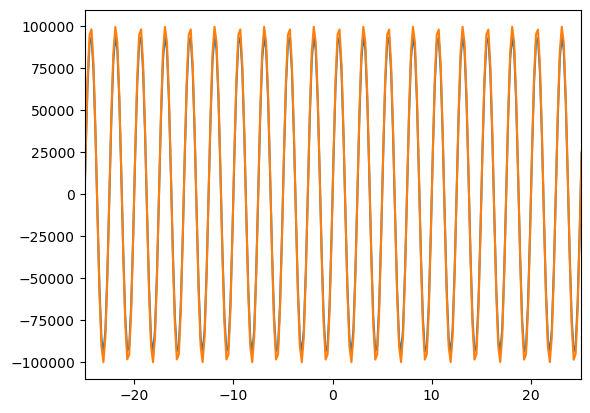

In [704]:
A_est, S_est = PALM(Xf, n=2, lamb=1000, nbIt = 1000)

Sf = sff.idct(S_est)

## improvement of the plots by using the same scale for the two plots

plt.figure()
plt.plot(x_abs, Sf[0])
plt.plot(x_abs,200000*np.sin(2*np.pi*0.05*x_abs))
plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs, Sf[1])
plt.plot(x_abs,100000*np.sin(2*np.pi*0.4*x_abs))
plt.xlim([-25,25])

In [705]:
print('Matrix A:', A)
print('Estimated matrix A:', A_est)

Matrix A: [[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
Estimated matrix A: [[0.55541085 0.24278254]
 [0.83157609 0.97008074]]
